In [1]:
# Common libraries for data cleaning and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import load # use to load an npz file
from scipy.signal import periodogram # use to graph a periodogram to get seasonality analysis
from sklearn.preprocessing import MinMaxScaler # use to normalize the data features

# keras library to create NN models
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# libraries for the metrics we will use (RMSE and Spearman)
from keras.metrics import RootMeanSquaredError
import scipy.stats as stats

/Users/tigerweng/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Set plot settings
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['grid.alpha'] = 0.5

In [3]:
data = load('./pems08.npz')

In [5]:
traffic_data = data[lst[0]]
data_dict = []
# loop for every timestep and every location and add as a single row
for timestep in range(traffic_data.shape[0]):
    for location in range(traffic_data.shape[1]):
        data_dict.append({
            "timestep" : timestep+1,
            "location" : location,
            "flow"     : traffic_data[timestep][location][0],
            "occupy"   : traffic_data[timestep][location][1],
            "speed"    : traffic_data[timestep][location][2]
        })

In [6]:
df = pd.DataFrame(data_dict)
df.to_csv("traffic.csv", index=False)

In [7]:
traffic = pd.read_csv("./traffic.csv")
print(len(traffic))
traffic.head()

3035520


,timestep,location,flow,occupy,speed
0,1,0,133.0,0.0603,65.8
1,1,1,210.0,0.0589,69.6
2,1,2,124.0,0.0358,65.8
3,1,3,145.0,0.0416,69.6
4,1,4,206.0,0.0493,69.4


In [19]:
COR_STEP = 1
pres = traffic[['flow', 'occupy', 'speed']][0:-(COR_STEP)].reset_index(drop=True)
future = traffic[['flow', 'occupy', 'speed']][COR_STEP:] \
    .reset_index(drop=True) \
    .add_suffix('_future')
val = pres.join(future)
val.corr()

,flow,occupy,speed,flow_future,occupy_future,speed_future
flow,1.000000,0.674039,-0.296332,0.535235,0.450192,-0.235030
occupy,0.674039,1.000000,-0.752040,0.445282,0.477379,-0.303858
speed,-0.296332,-0.752040,1.000000,-0.228266,-0.275180,0.233537
flow_future,0.535235,0.445282,-0.228266,1.000000,0.674040,-0.296331
occupy_future,0.450192,0.477379,-0.275180,0.674040,1.000000,-0.752040
speed_future,-0.235030,-0.303858,0.233537,-0.296331,-0.752040,1.000000


In [24]:
# creating 3-dimensional array for [timestep, timeframe, features]
def create_dataset(location, WINDOW_SIZE):
    
    # mask a certain location
    location_current = traffic[traffic["location"]==location].reset_index()
    
    location_current["hour"] = ((location_current["timestep"] - 1) // 12)
    grouped = location_current.groupby("hour").mean().reset_index()

    grouped['day'] = (grouped['hour'] // 24) % 7
    grouped['hour'] %= 24
    
    one_hot_hour = pd.get_dummies(grouped['hour'])
    one_hot_hour = one_hot_hour.add_prefix('hour_')
    
    # merge all the features together to get a total of 27 features
    hour_grouped = pd.concat([grouped[["occupy", "flow", "speed"]], one_hot_hour], axis=1)
    hour_grouped = np.array(hour_grouped)
    
    X, Y = [], []
    
    # add lag features (in reverse time order)
    for i in range(len(hour_grouped) - WINDOW_SIZE):
        X.append(hour_grouped[i:(i + WINDOW_SIZE)][::-1]) # reverse the order
        Y.append(hour_grouped[i + WINDOW_SIZE, 0]) # index 0 is occupy
    
    return X,Y 

In [25]:
# creating 4-th dimension for the locations
X, Y = [], []

for location in range(170):
    a,b = create_dataset(location, WINDOW_SIZE=24)
    X.append(a)
    Y.append(b)
    
X = np.moveaxis(X,0,-1)
Y = np.moveaxis(Y,0,-1)

print(X.shape)
print(Y.shape)

(1464, 24, 27, 170)
(1464, 170)


In [26]:
TRAIN_SIZE = 0.8
TEST_SIZE  = 0.2

train_size = int(len(X) * TRAIN_SIZE)
test_size  = int(len(X) * TEST_SIZE)

train_X, train_Y = X[:train_size], Y[:train_size]
test_X, test_Y = X[train_size:], Y[train_size:]

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(1171, 24, 27, 170)
(1171, 170)
(293, 24, 27, 170)
(293, 170)


In [27]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
train_X = scaler_X.fit_transform(train_X.reshape(train_X.shape[0] * train_X.shape[1], -1)) \
                   .reshape(train_X.shape[0], train_X.shape[1], -1)
test_X = scaler_X.transform(test_X.reshape(test_X.shape[0] * test_X.shape[1], -1)) \
                   .reshape(test_X.shape[0], test_X.shape[1], -1)
train_Y = scaler_Y.fit_transform(train_Y)
test_Y = scaler_Y.transform(test_Y)

In [29]:
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])),
    LSTM(256, return_sequences=False),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(170, activation='linear'),
])

model.compile(loss='mse', optimizer='adam', metrics=[RootMeanSquaredError()])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 256)           4963328   
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 170)               43690     
                                                                 
Total params: 5598122 (21.36 MB)
Trainable params: 55981

In [42]:
# Train the model
history = model.fit(train_X, train_Y, epochs=150, batch_size=32, validation_split=0.1, verbose=2)

Epoch 1/150
33/33 - 4s - loss: 0.0132 - root_mean_squared_error: 0.1149 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1070 - 4s/epoch - 121ms/step
Epoch 2/150
33/33 - 4s - loss: 0.0119 - root_mean_squared_error: 0.1093 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130 - 4s/epoch - 113ms/step
Epoch 3/150
33/33 - 4s - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1051 - 4s/epoch - 117ms/step
Epoch 4/150
33/33 - 4s - loss: 0.0103 - root_mean_squared_error: 0.1014 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1187 - 4s/epoch - 119ms/step
Epoch 5/150
33/33 - 4s - loss: 0.0098 - root_mean_squared_error: 0.0991 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1002 - 4s/epoch - 113ms/step
Epoch 6/150
33/33 - 4s - loss: 0.0098 - root_mean_squared_error: 0.0991 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068 - 4s/epoch - 114ms/step
Epoch 7/150
33/33 - 4s - loss: 0.0086 - root_mean_squared_error: 0.0928 - val_loss

KeyboardInterrupt: 

In [ ]:
def plot_training(training_history, text, width):
    history = training_history.history[text]
    
    # creates a moving average plot to reduce variations
    moving_average = [float("NaN") for i in range(width)]
    for i in range(width, len(history)+1):
        moving_average.append(np.mean(np.array(history[i-width:i+1])))
        
    plt.plot(history)
    plt.plot(moving_average)
    plt.title(text)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['value','moving average'], loc='upper left')
    plt.show()

In [ ]:
# Plots the loss (MSE and RMSE) of both test and validation data
WIDTH = 10
plot_training(history,'loss',WIDTH)
plot_training(history,'val_loss',WIDTH)
plot_training(history,'val_root_mean_squared_error',WIDTH)
plot_training(history,'root_mean_squared_error',WIDTH)

In [38]:
import spektral
from spektral.layers import GCNConv

batch_size = train_X_reshaped.shape[0]
timesteps = train_X_reshaped.shape[1]
N = train_X_reshaped.shape[2]
F = train_X_reshaped.shape[3]

# Flatten the time dimension into the batch dimension for the GCN step
X_train_gcn = train_X_reshaped.reshape((batch_size * timesteps, N, F))
X_test_gcn = test_X_reshaped.reshape((test_X_reshaped.shape[0] * timesteps, N, F))

# We have one fixed adjacency A_norm of shape (N, N).
# For batch processing, we can replicate A_norm for each sample:
A_train_gcn = np.stack([A_norm] * (batch_size * timesteps), axis=0)    
A_test_gcn = np.stack([A_norm] * (test_X_reshaped.shape[0] * timesteps), axis=0)

# Build a GCN model to produce embeddings from X and A
X_in_gcn = Input(shape=(N, F))
A_in_gcn = Input(shape=(N, N))

x = GCNConv(64, activation='relu')([X_in_gcn, A_in_gcn])
x = GCNConv(64, activation='relu')([x, A_in_gcn])

gcn_model = Model(inputs=[X_in_gcn, A_in_gcn], outputs=x)
gcn_model.compile(loss='mse', optimizer='adam')

X_train_gcn_out = gcn_model.predict([X_train_gcn, A_train_gcn], batch_size=32)
X_test_gcn_out = gcn_model.predict([X_test_gcn, A_test_gcn], batch_size=32)

X_train_gcn_out = X_train_gcn_out.reshape(batch_size, timesteps, N, 64)
X_test_gcn_out = X_test_gcn_out.reshape(test_X_reshaped.shape[0], timesteps, N, 64)

# Now build the LSTM model using the GCN embeddings
X_in_lstm = Input(shape=(timesteps, N, 64))
X_lstm = tf.keras.layers.Reshape((timesteps, N*64))(X_in_lstm)
X_lstm = LSTM(256, return_sequences=False)(X_lstm)
X_lstm = Dropout(0.2)(X_lstm)
X_lstm = Dense(256, activation='relu')(X_lstm)
X_lstm = Dropout(0.2)(X_lstm)
outputs_lstm = Dense(N, activation='linear')(X_lstm)

final_model = Model(inputs=X_in_lstm, outputs=outputs_lstm)
final_model.compile(loss='mse', optimizer=Adam(), metrics=['mse'])
final_model.summary()

# Train the final model
history = final_model.fit(X_train_gcn_out, train_Y, epochs=50, batch_size=32, validation_split=0.1, verbose=2)

test_pred = final_model.predict(X_test_gcn_out)
test_pred_scaled = scaler_Y.inverse_transform(test_pred)
test_actual_scaled = scaler_Y.inverse_transform(test_Y)

gnn_rmse = np.sqrt(np.mean((test_pred_scaled - test_actual_scaled)**2))
print("GNN Test RMSE:", gnn_rmse)

corr, pval = stats.spearmanr(test_actual_scaled.flatten(), test_pred_scaled.flatten())
print("GNN Test Spearman Correlation:", corr)


220/220 [==============================] - 1s 6ms/step


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 24, 170, 64)]     0         
                                                                 
 reshape (Reshape)           (None, 24, 10880)         0         
                                                                 
 lstm_4 (LSTM)               (None, 256)               11404288  
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 170)               4369

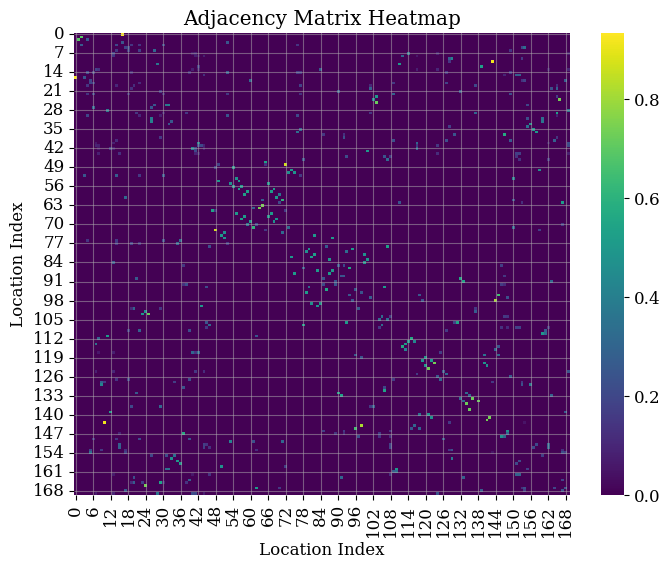

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# A_norm is your normalized adjacency matrix (N x N)
plt.figure(figsize=(8, 6))
sns.heatmap(A_norm, cmap='viridis')
plt.title("Adjacency Matrix Heatmap")
plt.xlabel("Location Index")
plt.ylabel("Location Index")
plt.show()


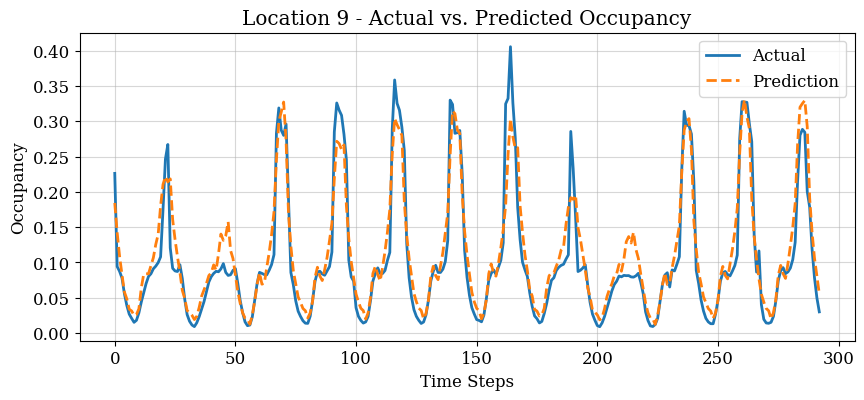

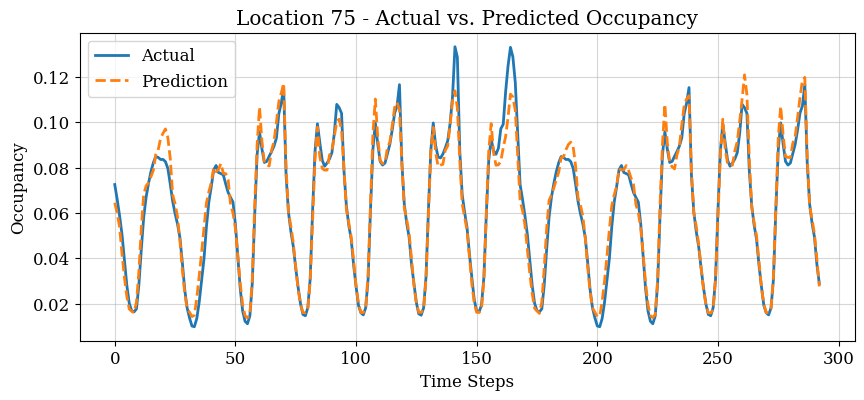

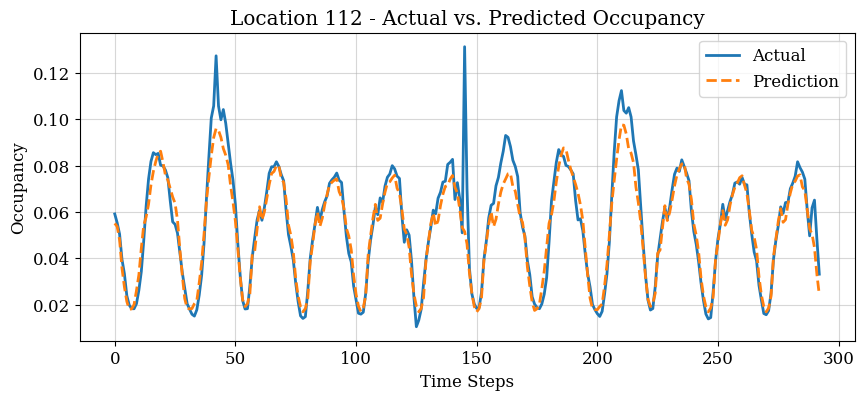

In [40]:
import random
locations_to_plot = random.sample(range(N), 3)  # pick 3 random locations

time_axis = np.arange(test_pred_scaled.shape[0])  # number of time steps in test

for loc in locations_to_plot:
    plt.figure(figsize=(10,4))
    plt.plot(time_axis, test_actual_scaled[:, loc], label='Actual', linewidth=2)
    plt.plot(time_axis, test_pred_scaled[:, loc], label='Prediction', linestyle='--', linewidth=2)
    plt.title(f"Location {loc} - Actual vs. Predicted Occupancy")
    plt.xlabel("Time Steps")
    plt.ylabel("Occupancy")
    plt.legend()
    plt.show()
